In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn,utils 
import mxnet.ndarray as F
from IPython.display import Audio
from scipy.io import wavfile

In [2]:
class One_Hot(nn.Block):
    def __init__(self, depth):
        super(One_Hot,self).__init__()
        self.depth = depth
        self.ones = nd.one_hot(nd.arange(depth),depth)
        #self.ones = torch.sparse.torch.eye(depth) # pytorch version
    def forward(self, X_in):
        X_in = X_in
        return self.ones[X_in,:]
        #return Variable(self.ones.index_select(0,X_in.data))
    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.depth)

In [3]:
class WaveNet(nn.Block):
    def __init__(self, mu=256,n_residue=32, n_skip= 512, dilation_depth=10, n_repeat=5):
        # mu: audio quantization size
        # n_residue: residue channels
        # n_skip: skip channels
        # dilation_depth & n_repeat: dilation layer setup
        super(WaveNet, self).__init__()
        self.dilation_depth = dilation_depth
        self.dilations = [2**i for i in range(dilation_depth)] * n_repeat
        self.one_hot = One_Hot(mu)
        with self.name_scope():
            self.from_input = nn.Conv1D(in_channels=mu, channels=n_residue, kernel_size=1)
            self.conv_sigmoid = nn.Sequential()
            self.conv_tanh = nn.Sequential()
            self.skip_scale = nn.Sequential()
            self.residue_scale = nn.Sequential()
            for d in self.dilations:
                self.conv_sigmoid.add(nn.Conv1D(in_channels=n_residue, channels=n_residue, kernel_size=2, dilation=d))
                self.conv_tanh.add(nn.Conv1D(in_channels=n_residue, channels=n_residue, kernel_size=2, dilation=d))
                self.skip_scale.add(nn.Conv1D(in_channels=n_residue, channels=n_skip, kernel_size=1, dilation=d))
                self.residue_scale.add(nn.Conv1D(in_channels=n_residue, channels=n_residue, kernel_size=1, dilation=d))
            self.conv_post_1 = nn.Conv1D(in_channels=n_skip, channels=n_skip, kernel_size=1)
            self.conv_post_2 = nn.Conv1D(in_channels=n_skip, channels=mu, kernel_size=1)
        
    def forward(self,x):
        output = self.preprocess(x)
        skip_connections = [] # save for generation purposes
        for s, t, skip_scale, residue_scale in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale):
            output, skip = self.residue_forward(output, s, t, skip_scale, residue_scale)
            skip_connections.append(skip)
        # sum up skip connections
        output = sum([s[:,:,-output.shape[2]:] for s in skip_connections])
        output = self.postprocess(output)
        return output
        
    def preprocess(self, x):
        output = F.transpose(self.one_hot(x).expand_dims(0),axes=(0,2,1))
        output = self.from_input(output)
        return output

    def postprocess(self, x):
        output = F.relu(x)
        output = self.conv_post_1(output)
        output = F.relu(output)
        output = self.conv_post_2(output)
        output = nd.reshape(output,(output.shape[1],output.shape[2]))
        output = F.transpose(output,axes=(1,0))
        return output
    
    def residue_forward(self, x, conv_sigmoid, conv_tanh, skip_scale, residue_scale):
        output = x
        output_sigmoid, output_tanh = conv_sigmoid(output), conv_tanh(output)
        output = F.sigmoid(output_sigmoid) * F.tanh(output_tanh)
        skip = skip_scale(output)
        output = residue_scale(output)
        output = output + x[:,:,-output.shape[2]:]
        return output, skip
    
    def generate_slow(self, x, n=100):
        res = list(x.asnumpy())
        for _ in range(n):
            x = nd.array(res[-sum(self.dilations)-1:])
            y = self.forward(x)
            #_, i = y.max(dim=1)
            res.append(y.argmax(1).asnumpy()[-1])
        return res
    

## sample test

In [6]:
net = WaveNet(mu=128)
net.initialize()

In [7]:
batch = nd.array(np.random.randint(0,128,10000).astype(np.long))

In [8]:
y = net(batch)

In [9]:
y.shape

(4885, 128)

In [10]:
%time y_gen2 = net.generate_slow(batch, 20)

CPU times: user 21.6 s, sys: 1.58 s, total: 23.2 s
Wall time: 12.9 s


In [11]:
len(y_gen2)

10020

## $\mu$-law encode and decode

In [4]:
def encode_mu_law(x, mu=256):
    mu = mu-1
    fx = np.sign(x)*np.log(1+mu*np.abs(x))/np.log(1+mu)
    return np.floor((fx+1)/2*mu+0.5).astype(np.long)

def decode_mu_law(y, mu=256):
    mu = mu-1
    fx = (y-0.5)/mu*2-1
    x = np.sign(fx)/mu*((1+mu)**np.abs(fx)-1)
    return x  

## sign wave generation

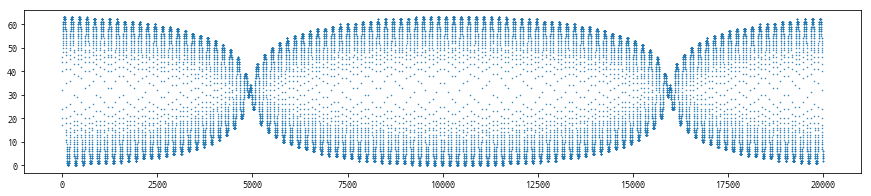

In [5]:
def sine_generator(seq_size = 6000, mu=256):
    framerate = 44100
    t = np.linspace(0,5,framerate*5)
    data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
    data = data/2
    while True:
        start = np.random.randint(0,data.shape[0]-seq_size)
        ys = data[start:start+seq_size]
        ys = encode_mu_law(ys,mu)
        yield nd.array(ys[:seq_size])
        
g = sine_generator(mu=64, seq_size=20000)
x = next(g)
plt.figure(figsize=[15,3])
plt.plot(list(x.asnumpy()),'.', ms=1)

## listen to signal

In [6]:
#y = np.array(x)
y = x.asnumpy()
y = decode_mu_law(y, 64)
Audio(y,rate=44100)
#Audio(y,rate=22000)

## network training

This network tries to generate the vibrating sine wave above. 
- The audio signal is quantized to 64 discrete integers.
- 24 channels in residue outputs
- 128 channels in skip outputs
- 20 dilation layers (n_repeat=2, dilation_depth=10)

In [7]:
net = WaveNet(mu=64,n_residue=24,n_skip=128,dilation_depth=10,n_repeat=2)
net.collect_params().initialize()
#set optimizer
trainer = gluon.Trainer(net.collect_params(),optimizer='adam',optimizer_params={'learning_rate':0.01 })
g = sine_generator(seq_size=2200,mu=64)
batch_size = 64
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [8]:
from tqdm import tqdm

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch 0, loss 569.0245971679688


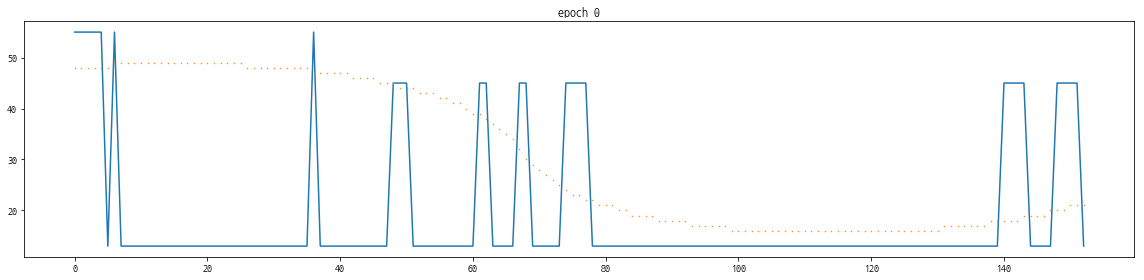

  1%|          | 10/1000 [02:34<4:15:30, 15.49s/it]

epoch 10, loss 210.47340393066406


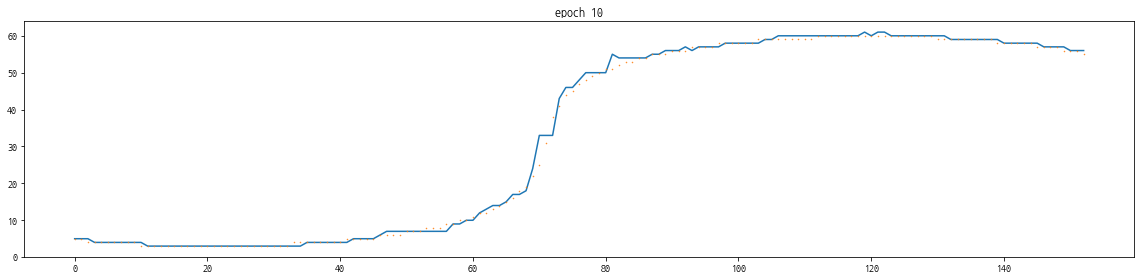

  1%|          | 12/1000 [03:06<4:15:41, 15.53s/it]

In [ ]:
loss_save = []
max_epoch = 1000
for epoch in tqdm(range(max_epoch)):
    loss = 0.0
    for _ in range(batch_size):
        batch = next(g)
        x = batch[:-1]
        with autograd.record():
            logits = net(x)
            sz = logits.shape[0]
            loss = loss + loss_fn(logits, batch[-sz:])
            #loss = loss/batch_size
        loss.backward()
        trainer.step(1,ignore_stale_grad=True)
    loss_save.append(nd.sum(loss).asscalar()/batch_size)
    # monitor progress
    if epoch%10==0:
        print('epoch {}, loss {}'.format(epoch, nd.sum(loss).asscalar()/batch_size))
        batch = next(g)
        logits = net(batch[:-1])
        #_, i = logits.max(dim=1)
        i = logits.argmax(1).asnumpy()
        plt.figure(figsize=[16,4])
        plt.plot(list(i))
        plt.plot(list(batch.asnumpy())[sum(net.dilations)+1:],'.',ms=1)
        plt.title('epoch {}'.format(epoch))
        plt.tight_layout()
        plt.show()